# IRIS PASSCAL - RT130 Data Processing

A Jupyter notebook by Glenn Thompson based on: https://www.passcal.nmt.edu/webfm_send/3035

You’ve offloaded a service run and have data from each RT130. Follow the steps in this document to convert the data to miniSEED and reorganize it into station/channel/day volumes. Then, create a stationXML for your experiment using Nexus (see step 7) before submitting data to PASSCAL. Program names are in italics. Unix commands and any command line arguments are on separate lines. Input files are denoted by < filename>. Additional documentation can be found on the PASSCAL website: https://www.passcal.nmt.edu/content/passive-source-seed-archiving-documentation

Import needed modules and set global variables

In [1]:
import os
import glob
import shutil
from pathlib import Path
import numpy as np
import pandas as pd

## STEP 1. Create an organized directory structure for your data. 
Start by creating a main directory for the project *(in this Jupyter Notebook, I use the variable REFTEKDIR for this main project directory)*. 

Under your main project directory, make a first level directory “SVC1” for service run number 1. For each subsequent service run create a new directory, e.g. SVC2, SVC3. Create directories in the SVC1 directory for the raw data files and log files. For example: 

    mkdir RAW
    mkdir LOGS

Move the raw data files (either .ZIP or CF folders) into the RAW directory, e.g.

    mv SVC1/ZIPFILES/*.ZIP SVC1/RAW/

<b>Glenn's variations:</b> While I sometimes used *Neo* to read the Compact Flash cards, compress the data to ZIP format, and then copy the data to the laptop, I mostly just copied the data using the MacOS command line as I found it quicker, e.g.

    cp -r /Volumes/UNTITLED/RT130-*/2* SVC1/RAW/
    
At the time of writing this Jupyter Notebook, I had already completed the field project and had all the data organized into a directory structure that looks like:

<b>Note:</b> The REFTEKDIR variable below must be set to the path of the parent directory of SVC1 (or SVC2, SVC3, etc.). If you set SERVICE_RUN = 1, the Jupyter Notebook will create the SVC1 directory underneath this (or SVC2 if you set it to 2).

In [21]:
#REFTEKDIR = '/raid/data/KennedySpaceCenter/duringPASSCAL/REFTEK_DATA' 
REFTEKDIR = '/home/thompsong/work/PROJECTS/KSCpasscal'
SERVICE_RUN = 2

yn = input('Is %s path to the main project directory correct? ' % REFTEKDIR)
if not (yn.lower() == 'yes' or yn.lower() == 'y'):
    REFTEKDIR = input('Enter correct path to main project directory: ')
    
yn = input('Is this service run %02d ? ' % SERVICE_RUN)
if not (yn.lower() == 'yes' or yn.lower() == 'y'):
    SERVICE_RUN = int(input('Enter correct service run number: '))
       
print('Setting paths for relative directories/files')
SVCDIR = os.path.join(REFTEKDIR, 'SVC%02d' % SERVICE_RUN)
RAWDIR = os.path.join(SVCDIR, 'RAW') 
LOGSDIR =  os.path.join(SVCDIR, 'LOGS')
CONFIGDIR = os.path.join(SVCDIR, 'CONFIG')
MSEEDDIR = os.path.join(REFTEKDIR, 'MSEED')
DAYSDIR = os.path.join(REFTEKDIR, 'DAYS')
RT2MS_OUTPUT = os.path.join(LOGSDIR, 'rt2ms.out')

print('Creating outline directory structure')
if not os.path.exists(REFTEKDIR):
    print("%s does not exist. Exiting" % REFTEKDIR)
    raise SystemExit("Killed!")  
subdirs = [SVCDIR, RAWDIR, LOGSDIR, CONFIGDIR, MSEEDDIR, DAYSDIR]
for thissubdir in subdirs:
    if not os.path.exists(thissubdir):
        print('Need to make %s' % thissubdir)
        os.mkdir(thissubdir)
        if not os.path.exists(thissubdir):
            print("%s does not exist & could not be created. Exiting" % thissubdir)
            raise SystemExit("Killed!") 
if os.path.exists(RT2MS_OUTPUT):
    os.remove(RT2MS_OUTPUT)
print('Outline directory structure created/exists')
print('Done')

Is /home/thompsong/work/PROJECTS/KSCpasscal path to the main project directory correct?  y
Is this service run 02 ?  y


Setting paths for relative directories/files
Creating outline directory structure
Outline directory structure created/exists
Done


### Parse RT130 9/* files to reconstruct digitizer-station history

In [22]:
#summary9file = '/media/sda1/summary9file.csv'
summary9file = os.path.join(SVCDIR, 'summary9file.csv')

STATIONS = ['BHP', 'TANK', 'FIRE', 'BCHH', 'DVEL', 'RBLAB']
dayfullpaths = sorted(glob.glob('%s/20?????' % RAWDIR))
if os.path.exists(summary9file):
    os.remove(summary9file)
count = 0
filehandle = open(summary9file, "w")
for thisdayfullpath in dayfullpaths:
    count = count + 1
    print('Processing %s (%d of %d)' % (thisdayfullpath, count, len(dayfullpaths) ))#, end="\r", flush=True)
    thisdaydir = os.path.basename(thisdayfullpath) # a directory like 2018365
    rt130files = sorted(glob.glob('%s/????/9/*' % thisdayfullpath))
    
    if rt130files:
        
        for rt130file in rt130files:
            #print(rt130file)
            output = os.popen('strings %s' % rt130file).read()
            if output: 
                for station in STATIONS:
                    firstindex = output.find(station)
                    if firstindex > -1:
                        break
                    
                if firstindex != -1:
                    pathparts = rt130file.split('/')
                    rt130 = pathparts[-3]
                    filehandle.write('%s, %s, %s\n' % (output[firstindex:firstindex+4], thisdaydir, rt130) )
         
        #if count>40:
        #    break
        
filehandle.close()
print('\nDone')

Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC02/RAW/2018290 (1 of 90)
/home/thompsong/work/PROJECTS/KSCpasscal/SVC02/RAW/2018290/91F8/9/003620000_00382700
/home/thompsong/work/PROJECTS/KSCpasscal/SVC02/RAW/2018290/91F8/9/013740000_00382700
/home/thompsong/work/PROJECTS/KSCpasscal/SVC02/RAW/2018290/91F8/9/023900000_00382700
/home/thompsong/work/PROJECTS/KSCpasscal/SVC02/RAW/2018290/91F8/9/034020000_00382700
/home/thompsong/work/PROJECTS/KSCpasscal/SVC02/RAW/2018290/91F8/9/044140000_00382700
/home/thompsong/work/PROJECTS/KSCpasscal/SVC02/RAW/2018290/91F8/9/054300000_00382700
/home/thompsong/work/PROJECTS/KSCpasscal/SVC02/RAW/2018290/91F8/9/064420000_00382700
/home/thompsong/work/PROJECTS/KSCpasscal/SVC02/RAW/2018290/91F8/9/074540000_00382700
/home/thompsong/work/PROJECTS/KSCpasscal/SVC02/RAW/2018290/91F8/9/084700000_00382700
/home/thompsong/work/PROJECTS/KSCpasscal/SVC02/RAW/2018290/91F8/9/094820000_00382700
/home/thompsong/work/PROJECTS/KSCpasscal/SVC02/RAW/2018290/91F8/9/1049

In [23]:
output = os.popen('sort %s | uniq' % summary9file).read()
#print(output)
lastStationDigitizerCombo = ""
lastline = ""

for thisline in output.split('\n'):
    try:
        (station, yyyyjjj, digitizer)  = thisline.split(',')
        thisStationDigitizerCombo = '%s%s' % (station, digitizer)
        #print(lastStationDigitizerCombo, thisStationDigitizerCombo)
        if lastStationDigitizerCombo != thisStationDigitizerCombo:
            print(lastline)
            print(thisline)
        lastStationDigitizerCombo = thisStationDigitizerCombo
        lastline = thisline
    except:
        pass
print(lastline)


BHP1, 2018338, 92B7
BHP1, 2019014, 92B7
BHP2, 2018290, 91F8
BHP2, 2019014, 91F8
BHP3, 2018290, 9D7C
BHP3, 2019014, 9D7C
BHP4, 2018290, 9338
BHP4, 2019014, 9338
BHP5, 2018290, 9406
BHP5, 2018338, 9406
BHP6, 2018290, AB13
BHP6, 2018346, AB13
BHP7, 2018290, 98E6
BHP7, 2018290, 98E6
BHP8, 2018290, 9BC5
BHP8, 2018290, 9BC5


### Parse RT130 1/* files to reconstruct digitizer-GPS_Position history
This generates a DataFrame/CSV file like:

<pre>
,Digitizer,yyyyjjj,Latitude,LatSTD
0,92B7,2018222,28.0595,2.8867513458681453e-05
1,92B7,2018223,28.0595,1.8559214542252517e-05
2,92B7,2018229,28.573463888888888,2.721655270429592e-06
3,92B7,2018230,28.573469444444445,1.7899429988238652e-06
4,92B7,2018231,28.573469444444445,2.6032870393506316e-06
5,92B7,2018233,28.573469444444445,3.552713678800501e-15
6,92B7,2018234,28.573469444444445,3.552713678800501e-15
7,92B7,2018235,28.573469444444445,3.552713678800501e-15
</pre>

The next task will be to detect dates on which a digitizer was moved by examining plots of GPS Latitude & standard deviation.


In [24]:
def find_all(a_str, sub):
    start = 0
    while True:
        start = a_str.find(sub, start)
        if start == -1: return
        yield start
        start += len(sub) # use start += 1 to find overlapping matches

#list(find_all('spam spam spam spam', 'spam'))

positionDF = pd.DataFrame(columns = ['Digitizer', 'yyyyjjj', 'Latitude', 'LatSTD'])
digitizerList = list()
yyyyjjjList = list()
latitudeList = list()
latSTDList = list()
dayfullpaths = sorted(glob.glob('%s/20?????' % RAWDIR))
#summary1file = '/media/sda1/summary1file.csv'
summary1file = os.path.join(SVCDIR, 'summary1file.csv')
if os.path.exists(summary1file):
    os.remove(summary1file)
count = 0
#filehandle = open(summary1file, "w")
for thisdayfullpath in dayfullpaths:
    count = count + 1
    #print('Processing %s (%d of %d)' % (thisdayfullpath, count, len(dayfullpaths) ), end="\r", flush=True)
    thisdaydir = os.path.basename(thisdayfullpath) # a directory like 2018365
    digitizerpaths = sorted(glob.glob('%s/????' % thisdayfullpath))
    for digitizerpath in digitizerpaths:
        thisdigitizer = os.path.basename(digitizerpath)
        rt130files = sorted(glob.glob('%s/1/*' % digitizerpath))
        if rt130files:
            all_positions = list()
            for rt130file in rt130files:
                #print('Processing %s' % rt130file, end="\r", flush=True)
                
                output = os.popen('strings %s' % rt130file).read()
                if output: 
                    
                    all_indexes = list(find_all(output, 'POSITION'))
                
                    for each_index in all_indexes:
                        
                        Ndeg = output[each_index+11:each_index+13]
                        Nmin = output[each_index+14:each_index+16]
                        Nsec = output[each_index+17:each_index+22]
                        Ndecdeg = float(Ndeg) + float(Nmin)/60 + float(Nsec)/3600
                        
                        if Ndecdeg > 28.0 and Ndecdeg < 29.0:
                            #print(output[each_index+11:each_index+22], " ", Ndecdeg)
                            all_positions.append(Ndecdeg)
            if all_positions:  
                all_positions_np = np.array(all_positions)
                #print(all_positions_np)
                #print(np.median(all_positions_np))
                #print('%s, %s, %f, %f\n' % (thisdigitizer, thisdaydir, np.median(all_positions_np), np.std(all_positions_np)) )
                #filehandle.write('%s, %s, %f\n' % (thisdigitizer, thisdaydir, np.median(all_positions_np)  ) )
                digitizerList.append(thisdigitizer)
                yyyyjjjList.append(thisdaydir)
                latitudeList.append(np.median(all_positions_np))
                latSTDList.append(np.std(all_positions_np))
         
    #if count>20:
    #    break

        
#filehandle.close()
positionDF['Digitizer'] = digitizerList
positionDF['yyyyjjj'] = yyyyjjjList
positionDF['Latitude'] = latitudeList
positionDF['LatSTD'] = latSTDList

positionDF.to_csv(summary1file)

print('\nDone')


Done


#### Convert yyyyjjj strings to datetime objects

In [25]:
import datetime
#print(positionDF)
dates = list()
for thisyyyyjjj in positionDF['yyyyjjj']:
    thisdate = datetime.datetime.strptime(thisyyyyjjj, "%Y%j").date()
    dates.append(thisdate)
#print(dates)
positionDF['dates']=dates

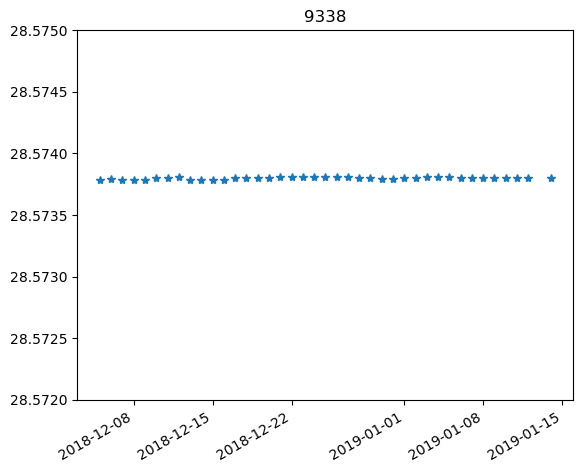

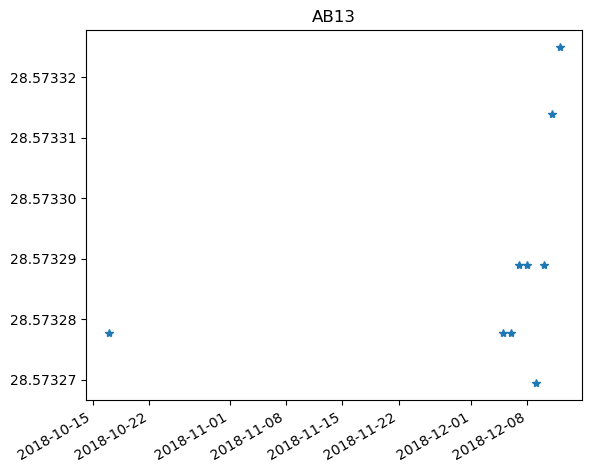

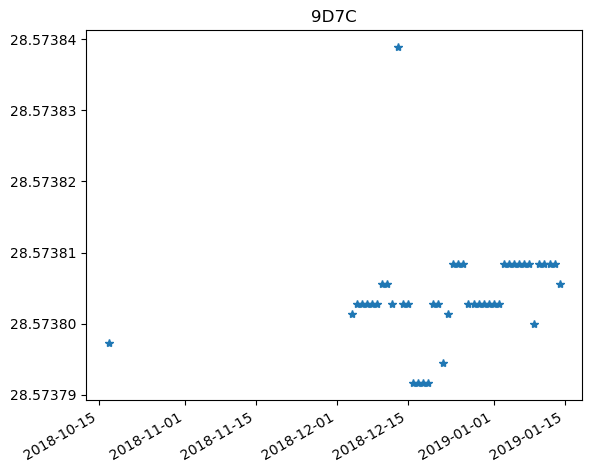

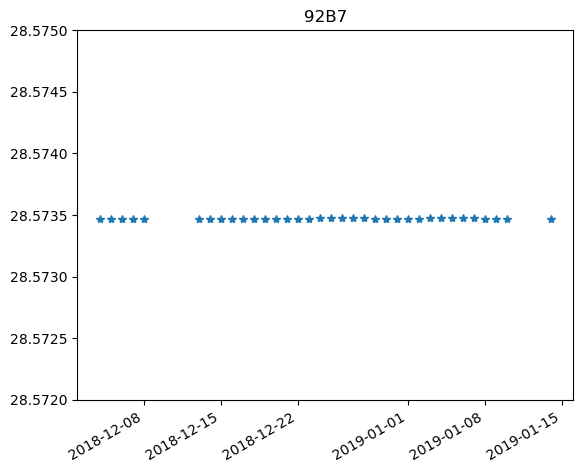

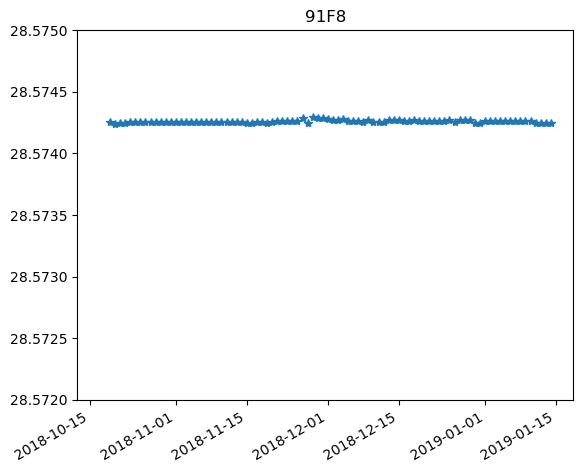

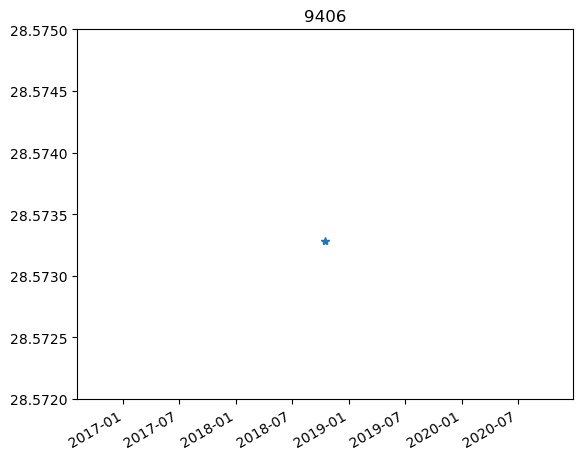

In [26]:
import matplotlib.pyplot as plt
plt.rcParams['axes.formatter.useoffset'] = False # do not allow relative y-labels

allDigitizers = list(set(digitizerList))
for digitizer in allDigitizers:
    subsetDF = positionDF[positionDF['Digitizer']==digitizer]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot_date(subsetDF['dates'], subsetDF['Latitude'],'*')  
    subsetDF.to_csv('latitude_' + digitizer + '.csv')
    ax.set_title(digitizer)
    if not (digitizer == 'AB13' or digitizer == '9D7C'):
        ax.set_ylim(28.572, 28.575)
    #xt = ax.get_xticks()
    #ax.set_xticks(xt[0::30])
    for xtl in ax.get_xticklabels():
        xtl.set_rotation(30)
        xtl.set_horizontalalignment('right')
    #plt.tight_layout()

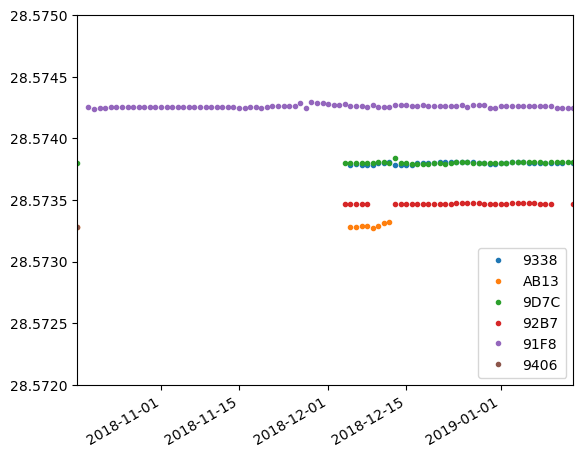

In [27]:
import matplotlib.pyplot as plt
allDigitizers = list(set(digitizerList))
fig = plt.figure()
ax = fig.add_subplot(111)
for digitizer in allDigitizers:
    subsetDF = positionDF[positionDF['Digitizer']==digitizer]
    ax.plot_date(subsetDF['dates'], subsetDF['Latitude'],'.', label=digitizer)  
    
#xt = ax.get_xticks()
#ax.set_xticks()
ax.set_xlim(dates[0],dates[-1])
for xtl in ax.get_xticklabels():
    xtl.set_rotation(30)
    xtl.set_horizontalalignment('right')
plt.legend()
ax.set_ylim(28.51, 28.58)
plt.savefig('digitizer_lats.png')
ax.set_ylim(28.572, 28.575)
plt.savefig('digitizer_lats_zoomed.png')
#plt.tight_layout()

## STEP 2. Create the parameter file(s). 
The parameter file is used by *rt2ms* to assign header information to the miniSEED files. *rt2ms* is a PASSCAL program that generates miniSEED formatted files from REFTEK RT130 raw files. In addition, *rt2ms* also modifies the headers. In the SVC1 directory, use a text editor and information from your field notes to create an ASCII parameter file (parfile) following the examples at https://www.passcal.nmt.edu/webfm_send/3035.

<b>Glenn's variations</b>: PASSCAL instructions assume you construct a par file by hand for each network layout. However, I construct an Antelope-style *dbbuild_batch* pf file by hand for each network layout, and then use the PASSOFT program *batch2par* to convert this to a par file (in combination with 2 *sed* (Unix stream editor) commands to fix this. You can see *batch2par* and *sed* commands used below.

<b>Update 20241110</b>
Today I downloaded and installed the latest conda version of passoft3, and this no longer includes batch2par. Thus, I need to hand-edit the par files.
Furthermore, rt2ms has changed. It no longer has -F, -L or -Y command line arguments. I'm trying to work out how to use it - it seems to require a different folder organization, as it doesn't like multiple digitizer folders in the same YYYYJJJ directory.
And finally, the *.par format has changed. A blank 'location' columns is now needed, as in network.station.location.channel (SEED id). And a final 'implment_time' column is needed in UTCDateTime.isoformat() with 6-digit microseconds and perhaps a 'Z' on end.

In [28]:
print('For each dbbuild_batch pf file, create a corresponding par file')
pffiles = sorted(glob.glob('%s/locations*.pf' % CONFIGDIR)) # changed network to locations

for pffile in pffiles:
    parfile = pffile[:-2] + 'par' # 
    print('- %s, %s' % (pffile, parfile)) 
            
    # Create the corresponding parfile if it does not already exist
    if not os.path.exists(parfile): 
        if commandExists('batch2par'): 
            os.system("batch2par %s -m > %s" % (pffile, parfile))
            if os.path.exists(parfile): 
                # Edit the par file
                os.system("sed -i -e 's/rs200spsrs;/1;         /g' %s" % parfile)
                os.system("sed -i -e 's/x1/32/g' %s" % parfile);  
            else:
                print("- batch2par failed")
                raise SystemExit("Killed!")
        else:
            raise SystemExit("Killed!")
print('All pf files now have a corresponding par file')
print('Done')

For each dbbuild_batch pf file, create a corresponding par file
- /home/thompsong/work/PROJECTS/KSCpasscal/SVC02/CONFIG/locations20181017.pf, /home/thompsong/work/PROJECTS/KSCpasscal/SVC02/CONFIG/locations20181017.par
All pf files now have a corresponding par file
Done


### modify existing par file


In [52]:
parfiles = sorted(glob.glob('%s/locations*.par' % CONFIGDIR)) # changed network to locations

for parfile in parfiles:
    os.system(f"cat {parfile}")
    newparfile = parfile.replace('.par', '.par.reformatted')
    os.system(f'sed -e "s/[[:space:]]\+/ /g"  {parfile} > {newparfile}')
    #os.system(f"cat {newparfile}")
    print('removing comment\n')
    newparfile2 = newparfile.replace('reformatted', 'uncommented')
    os.system(f'sed -e "1s/#//" {newparfile} > {newparfile2}')
    #os.system(f"cat {newparfile2}")
    df = pd.read_csv(newparfile2, sep=';', index_col=None)
    df['location']=''
    datestr = os.path.basename(parfile).replace('locations','').replace('.par','')
    df['implement_time'] = obspy.UTCDateTime.strptime(datestr, '%Y%m%d').isoformat()+'.000000Z'
    newparfile3 = parfile.replace('.par', '.par.new')
    df = df[['das',' refchan', ' refstrm', ' netcode', ' station', 'location', ' channel', ' samplerate', ' gain', 'implement_time']]
    print(df)
    df.to_csv(newparfile3, index=False, sep=';')
    #newparfile4 = parfile.replace(".par", ".par.new")
    #os.system(f'sed -e "1s/das/#das/" {newparfile3} > {newparfile4}')
    print('final output\n')
    #os.system(f"cat {newparfile4}")
    os.system(f"sed -i 's/\;/\; /g; s/\;\s\+/\; /g' {newparfile3}")
    os.system(f"cat {newparfile3}")

print('All par files now have been converted to new format')
print('Done')

#das; refchan; refstrm; netcode; station; channel; samplerate; gain
91F8;	1;	1;         	1R;	BHP2;	EHZ;	200;	32
91F8;	2;	1;         	1R;	BHP2;	EH1;	200;	32
91F8;	3;	1;         	1R;	BHP2;	EH2;	200;	32
91F8;	1;	9;		1R;	BHP2;	VM1;	0.1;	32
91F8;	2;	9;		1R;	BHP2;	VM2;	0.1;	32
91F8;	3;	9;		1R;	BHP2;	VM3;	0.1;	32
92B7;	1;	1;         	1R;	BHP1;	EHZ;	200;	32
92B7;	2;	1;         	1R;	BHP1;	EH1;	200;	32
92B7;	3;	1;         	1R;	BHP1;	EH2;	200;	32
92B7;	1;	9;		1R;	BHP1;	VM1;	0.1;	32
92B7;	2;	9;		1R;	BHP1;	VM2;	0.1;	32
92B7;	3;	9;		1R;	BHP1;	VM3;	0.1;	32
9338;	1;	1;         	1R;	BHP4;	EHZ;	200;	32
9338;	2;	1;         	1R;	BHP4;	EH1;	200;	32
9338;	3;	1;         	1R;	BHP4;	EH2;	200;	32
9338;	1;	9;		1R;	BHP4;	VM1;	0.1;	32
9338;	2;	9;		1R;	BHP4;	VM2;	0.1;	32
9338;	3;	9;		1R;	BHP4;	VM3;	0.1;	32
9406;	1;	1;         	1R;	BHP5;	EHZ;	200;	32
9406;	2;	1;         	1R;	BHP5;	EH1;	200;	32
9406;	3;	1;         	1R;	BHP5;	EH2;	200;	32
9406;	1;	9;		1R;	BHP5;	VM1;	0.1;	32
9406;	2;	9;		1R;	BHP5;	VM2;	0.1;	32
9406;	3;

In [35]:
dayfullpaths = sorted(glob.glob('%s/20?????' % RAWDIR))
TESTDIR = os.path.join(REFTEKDIR, 'TEST')
print(os.listdir(CONFIGDIR))
datalogger = '91F8'
for thisdayfullpath in dayfullpaths:
    print('Processing %s' % thisdayfullpath)
    thisdaydir = os.path.basename(thisdayfullpath) # a directory like 2018365
    dataloggerdir = os.path.join(thisdayfullpath, datalogger)
    outputdir = os.path.join(TESTDIR, thisdaydir, datalogger)
    print(dataloggerdir, '\t->\t',outputdir)
    if os.path.isdir(dataloggerdir):
        if not os.path.isdir(outputdir):
            os.makedirs(outputdir)
        
        os.system(f"cp -r {dataloggerdir} {outputdir}")
    

['locations20181017.par.new', 'locations20181017.par', 'locations20181017.pf']
Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC02/RAW/2018290
/home/thompsong/work/PROJECTS/KSCpasscal/SVC02/RAW/2018290/91F8 	->	 /home/thompsong/work/PROJECTS/KSCpasscal/TEST/2018290/91F8
Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC02/RAW/2018291
/home/thompsong/work/PROJECTS/KSCpasscal/SVC02/RAW/2018291/91F8 	->	 /home/thompsong/work/PROJECTS/KSCpasscal/TEST/2018291/91F8
Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC02/RAW/2018292
/home/thompsong/work/PROJECTS/KSCpasscal/SVC02/RAW/2018292/91F8 	->	 /home/thompsong/work/PROJECTS/KSCpasscal/TEST/2018292/91F8
Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC02/RAW/2018293
/home/thompsong/work/PROJECTS/KSCpasscal/SVC02/RAW/2018293/91F8 	->	 /home/thompsong/work/PROJECTS/KSCpasscal/TEST/2018293/91F8
Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC02/RAW/2018294
/home/thompsong/work/PROJECTS/KSCpasscal/SVC02/RAW/2018294/

In [53]:
# test rt2ms
TESTDIR2 = TESTDIR + "2"
PARFILE = os.path.join(CONFIGDIR, 'locations20181017.par.new')
MSEEDIR = os.path.join(TESTDIR2, 'MSEED')
cmd = f"rt2ms -d {TESTDIR2} -p {PARFILE} -o {MSEEDDIR}"
print(cmd)
os.system(cmd)

rt2ms -d /home/thompsong/work/PROJECTS/KSCpasscal/TEST2 -p /home/thompsong/work/PROJECTS/KSCpasscal/SVC02/CONFIG/locations20181017.par.new -o /home/thompsong/work/PROJECTS/KSCpasscal/MSEED
2024-11-10 13:40:55 - INFO - rt2ms program starting
2024-11-10 13:40:55 - INFO - Version: 2023.4.2.0
2024-11-10 13:40:55 - INFO - Parsing parameter file '/home/thompsong/work/PROJECTS/KSCpasscal/SVC02/CONFIG/locations20181017.par.new'
2024-11-10 13:40:55 - INFO - Parameter file:
das; refchan; refstrm; netcode; station; location; channel; samplerate; gain; implement_time
91F8; 1; 1; 1R; BHP2; ; EHZ; 200.0; 32; 2018-10-17T00:00:00.000000Z
91F8; 2; 1; 1R; BHP2; ; EH1; 200.0; 32; 2018-10-17T00:00:00.000000Z
91F8; 3; 1; 1R; BHP2; ; EH2; 200.0; 32; 2018-10-17T00:00:00.000000Z
91F8; 1; 9; 1R; BHP2; ; VM1; 0.1; 32; 2018-10-17T00:00:00.000000Z
91F8; 2; 9; 1R; BHP2; ; VM2; 0.1; 32; 2018-10-17T00:00:00.000000Z
91F8; 3; 9; 1R; BHP2; ; VM3; 0.1; 32; 2018-10-17T00:00:00.000000Z
92B7; 1; 1; 1R; BHP1; ; EHZ; 200.0; 

Traceback (most recent call last):
  File "/home/thompsong/miniconda3/envs/passoft3/bin/rt2ms", line 8, in <module>
    sys.exit(main())
  File "/home/thompsong/miniconda3/envs/passoft3/lib/python3.10/site-packages/rt2ms_py3/rt2ms_py3.py", line 224, in main
    rt130s.create_log(unit_id)
  File "/home/thompsong/miniconda3/envs/passoft3/lib/python3.10/site-packages/rt2ms_py3/rt130_files.py", line 183, in create_log
    rt130_soh = Rt130File.get_reftek130_from_file_soh(rt130_file.path)
  File "/home/thompsong/miniconda3/envs/passoft3/lib/python3.10/site-packages/rt2ms_py3/rt130_files.py", line 79, in get_reftek130_from_file_soh
    rt._data = _initial_unpack_packets_soh(string)
  File "/home/thompsong/miniconda3/envs/passoft3/lib/python3.10/site-packages/obspy_replace/soh_packet.py", line 935, in _initial_unpack_packets_soh
    result['time'][:] += [_get_nanoseconds_for_start_of_year(y)
  File "/home/thompsong/miniconda3/envs/passoft3/lib/python3.10/site-packages/obspy_replace/soh_packet

256

### helper functions for part 3

*chooseCorrectParFile* selects the par file with YYYYJJJ closest to, but not exceeding, the day of Reftek data we are trying to process. For example, for 2018200 (200th day of year 2018), we match network2018200.par if it exists. Otherwise, network2018199.par is the best match, if it exists. Or whatever the closest pf is *before* the data day. But network2018201.par is not a match, since the existence of that pf would indicate the network changed on that day, so it was no longer applicable to 2018200 data.

*commandExists* checks if PASSOFT/DMC commands are installed before we try to use them.

In [18]:
import obspy
def chooseCorrectParFile(yyyyjjj):
    correctparfile = ""
    parfilelist = sorted(glob.glob('%s/locations20*.par' % CONFIGDIR)) # network to locations
    for thisparfile in parfilelist:
        parts = thisparfile.split('locations')
        datestr = parts[1].replace('.par','')
        if len(datestr)==8:
            datestr = obspy.UTCDateTime.strptime(datestr, '%Y%m%d').strftime('%Y%J')
        if datestr < yyyyjjj:
            correctparfile = thisparfile
    return correctparfile

def commandExists(command):
    output = os.popen('which %s' % command).read()
    if output:
        return True
    else:
        print('Command %s not found.' % command)
        print('Make sure the PASSOFT tools are installed on this computer, and available on the $PATH')
        return False

### STEP 3: Convert your data into miniSEED files. 
In the service run directory, convert the raw RT130 data to miniSEED. Typing *rt2ms -h* shows a list of available options. 

If raw data is in decompressed folders, use the following commands: 
<pre>
    ls -d SVC1/RAW/*.cf > file.lst 
    rt2ms -F file.lst -Y -L -o MSEED/ -p <parfile> >& rt2ms.out 
</pre>
The (-F) flag will process all files in the named list, (‐Y) puts the data in yearly directories, (-L) outputs .log and, if created, .err files, (‐o) creates an output directory, MSEED, and (‐p) points to your parfile. 

If raw data is in ZIP files: 
<pre>
    rt2ms ‐D SVC1/RAW/ ‐Y ‐L -o MSEED/ ‐p <parfile> >& rt2ms.out 
</pre>
The (‐D) flag will process all .ZIP files in a specified directory, instead of in a file list as in the previous example. 

When *rt2ms* finishes, move all of your log and .err files from the MSEED directory to the LOGS directory that you created in step 1. 

After running *rt2ms* the MSEED directory structure should look something like the example below. In the MSEED directory there will be .log files and possibly .err files along with a  subdirectory for each year that contains day directories for each stream.

In [ ]:
    # Find the corresponding parameter file for this day of the experiment
    parfile = chooseCorrectParFile(thisdaydir)
    if os.path.exists(parfile):                
        # Par file must exist if we got here. Run rt2ms.
        # Here we would ideally check that we have a full set of corresponding 0/, 1/ and 9/ files,
        # and we would also check if the hourly MSEED file already exists, and only run this if it does not
        if commandExists('rt2ms'): 
            tmplistfile = 'tmpfilelist.txt'
            rt130files = sorted(glob.glob('%s/????/[19]/*' % thisdayfullpath))
            if rt130files:
                with open(tmplistfile, 'w') as filehandle:
                    #for rt130file in rt130files:
                    #    filehandle.write('%s\n' % rt130file)
                    filehandle.writelines("%s\n" % listitem for listitem in rt130files)    
                #os.system('cat %s' % tmplistfile)
                #input('<ENTER> to continue')
                #os.system('ls %s/????/1/* > %s' % (thisdayfullpath, tmplistfile) )
                #os.system('ls %s/????/9/* >> %s' % (thisdayfullpath, tmplistfile) )


                # We can check the following RT2MS_OUTFILE if rt2ms fails
                os.system("rt2ms -F %s -Y -L -v -p %s -o %s >> %s" % (tmplistfile, parfile, MSEEDDIR, RT2MS_OUTPUT))
                os.remove(tmplistfile) # remove it here so we can never get the wrong one

                # move all *.log files to the LOGS directory
                for src_file in Path(MSEEDDIR).glob('*.log'):
                    shutil.copy(src_file, LOGSDIR)

                # move all *.err files to the LOGS directory
                for src_file in Path(MSEEDDIR).glob('*.err'):
                    shutil.copy(src_file, LOGSDIR)         
                
        else:
            raise SystemExit("Killed!")
        
    else:
        print('- no corresponding parameter file found')
        
if dayfullpaths:
    print('FINISHED CONVERTING REFTEK DATA TO MINISEED HOURLY FILES')
else:
    print('No directories like RAW/YYYYJJJ found')
print('Done')    

['1R.LOC00.xml', 'locations20180810.pf', 'locations20180810.par']
Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018222


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018223


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018224


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018225


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018226


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018227


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018228


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018229


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018230


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018231


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018232


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018233


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018234


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018235
FINISHED CONVERTING REFTEK DATA TO MINISEED HOURLY FILES
Done


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


In [19]:
dayfullpaths = sorted(glob.glob('%s/20?????' % RAWDIR))
print(os.listdir(CONFIGDIR))
for thisdayfullpath in dayfullpaths:
    print('Processing %s' % thisdayfullpath)
    thisdaydir = os.path.basename(thisdayfullpath) # a directory like 2018365
    
    # Find the corresponding parameter file for this day of the experiment
    parfile = chooseCorrectParFile(thisdaydir)
    if os.path.exists(parfile):                
        # Par file must exist if we got here. Run rt2ms.
        # Here we would ideally check that we have a full set of corresponding 0/, 1/ and 9/ files,
        # and we would also check if the hourly MSEED file already exists, and only run this if it does not
        if commandExists('rt2ms'): 
            tmplistfile = 'tmpfilelist.txt'
            rt130files = sorted(glob.glob('%s/????/[19]/*' % thisdayfullpath))
            if rt130files:
                with open(tmplistfile, 'w') as filehandle:
                    #for rt130file in rt130files:
                    #    filehandle.write('%s\n' % rt130file)
                    filehandle.writelines("%s\n" % listitem for listitem in rt130files)    
                #os.system('cat %s' % tmplistfile)
                #input('<ENTER> to continue')
                #os.system('ls %s/????/1/* > %s' % (thisdayfullpath, tmplistfile) )
                #os.system('ls %s/????/9/* >> %s' % (thisdayfullpath, tmplistfile) )


                # We can check the following RT2MS_OUTFILE if rt2ms fails
                os.system("rt2ms -F %s -Y -L -v -p %s -o %s >> %s" % (tmplistfile, parfile, MSEEDDIR, RT2MS_OUTPUT))
                os.remove(tmplistfile) # remove it here so we can never get the wrong one

                # move all *.log files to the LOGS directory
                for src_file in Path(MSEEDDIR).glob('*.log'):
                    shutil.copy(src_file, LOGSDIR)

                # move all *.err files to the LOGS directory
                for src_file in Path(MSEEDDIR).glob('*.err'):
                    shutil.copy(src_file, LOGSDIR)         
                
        else:
            raise SystemExit("Killed!")
        
    else:
        print('- no corresponding parameter file found')
        
if dayfullpaths:
    print('FINISHED CONVERTING REFTEK DATA TO MINISEED HOURLY FILES')
else:
    print('No directories like RAW/YYYYJJJ found')
print('Done')    

['1R.LOC00.xml', 'locations20180810.pf', 'locations20180810.par']
Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018222


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018223


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018224


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018225


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018226


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018227


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018228


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018229


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018230


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018231


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018232


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018233


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018234


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


Processing /home/thompsong/work/PROJECTS/KSCpasscal/SVC00/RAW/2018235
FINISHED CONVERTING REFTEK DATA TO MINISEED HOURLY FILES
Done


usage: rt2ms [-h] [-d path2rt30_cfdir] [-D path2list_cfdirs] [-p path2parfile]
             [-o output_dir] [-e] [-X]
rt2ms: error: unrecognized arguments: -F tmpfilelist.txt -Y -L -v


## STEP 4: Reorganize the miniSEED data into station/channel/day volumes.

*dataselect* is a DMC program that allows for the extracting and sorting of miniSEED data (https://github.com/iris-edu/dataselect). This will read the data from the MSEED directory and convert them into day volumes with the required naming format: 

    dataselect -A DAYS/%s/%s.%n.%l.%c.%Y.%j MSEED/Y*/*/* 

The (-A) flag writes file names in the specified custom format. The format flags are (s) for station, (n) for netcode, (l) for location, (c) for channel name, (Y) for year, and (j) for Julian date. See the help menu for more details on options (*dataselect -h*). Depending on how much data you have, you may need to run *dataselect* in a loop that runs over the different days or stations in your experiment.

<b>Please note:</b> PASSCAL want data to be organized in BUD format. *dataselect -h* reveals that there is a BUD format option built in directly, so I attempt to use that here instead. This command is easier: 

    dataselect -BUD MSEED/Y*/*/* 
    
However, I do loop over year and day directories (as suggested) so that *dataselect* is not trying to deal with a file list that is too long for it or the operating system to handle.

In [ ]:
if commandExists('dataselect'): 
    # SCAFFOLD. I need to install this from github. And then figure out how to
    # substitute for station, netcode, location, channel name, year and julian day
    # May need to lop over different stations (I already do by day)
    mseedyearfullpaths = sorted(glob.glob('%s/Y20??' % MSEEDDIR))
    for thismseedyearfullpath in mseedyearfullpaths:
        print('Processing %s' % thismseedyearfullpath)  
        mseeddayfullpaths = sorted(glob.glob('%s/R*.01' % thismseedyearfullpath))
        for thismseeddayfullpath in mseeddayfullpaths:
            print('dataselect: Processing %s' % thismseeddayfullpath)
            #os.system('dataselect  -A %s/%s/%s.%n.%l.%c.%Y.%j  %s/*.m' % (DAYSDIR, thismseeddayfullpath))
            os.system('dataselect -v -BUD %s %s/*.m' % (DAYSDIR, thismseeddayfullpath) )

## STEP 5: Confirm your station and channel names
In the DAYS folder just created by dataselect, check to see if you have folders for each of your stations. The data should be organized into those folders in station/channel/day volumes named STA.NET.LOC.CHAN.YEAR.JULDAY. For example: BA01.XR..HHZ.2018.039 (The .. after XR is where the location code would be if needed).

If your parfile was incomplete (i.e. missing stations or channels), there will be one or more folders named with the RT130 serial numbers (e.g. 9306) instead of the desired station name (e.g. ME42). To change any miniSEED headers to correct a station name, network code, etc., see the *fixhdr* doc on the PASSCAL website (see link on the first page). After you have modified the headers with *fixhdr*, rename the files so that the station‐network‐location‐channel codes in the miniSEED file names match the corrected headers.  

## STEP 6. Perform quality control of waveforms and logs. 
Verify the data quality by reviewing the traces and log files (with *logpeek* and *pql*). Obvious signs of trouble include loss of GPS timing, overlaps, gaps, corrupted files, etc. Make a note of any problems. Use *fixhdr* to correct mark timing issues, and/or to convert the files to big endianess if they are not already. For more information on how to use these tools, refer to the appropriate documentation on the PASSCAL website (see link on the first page).

## STEP 7. Create metadata for your experiment. 
Use *Nexus* to generate a stationXML file for your experiment metadata. See the “Metadata Generation with Nexus in a Nutshell” document on the PASSCAL website (see link on first page).

## STEP 8. Send miniSEED data to PASSCAL. 
Please drop a note, with your PASSCAL project name in the subject, to <mailto>data_group@passcal.nmt.edu</mailto> before sending the data to PASSCAL so that we can set up a receiving area. Attach the stationXML created with Nexus to this email unless it is larger than 5Mb. Use our tool *data2passcal* to send the data: 

    data2passcal DAYS/ 

*data2passcal* will scan all subdirectories of the DAYS folder and send any miniSEED files that have the correct file names.
